#  Boxplot for PTEN trans effect on MCM2 in Gbm

This notebook creates a boxplot for the trans effect of PTEN cnv deletions in Gbm. 

Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u

import sys
import plot_utils as p

Functions:

format_df prepares a data frame with PTEN proteomics and PTEN mutation types from get_genotype_all_vars.

format_pval_annotation is used to add marks to the boxplot. A star represents significant p-value and "ns" represents a nonsignificant p-value.

In [6]:
# Returns a dataframe with proteomics and mutation type

def format_df(cancer_object, trans_gene, gene_in = 'PTEN'):
    mut_type = cancer_object.get_genotype_all_vars(gene_in)
    
    if cancer_object.get_cancer_type() not in ('luad'):
        # Keep only tumor samples from proteomics
        prot_and_mutations = cancer_object.join_omics_to_mutations(
            mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = trans_gene)
        prot_and_mutations = prot_and_mutations[prot_and_mutations.Sample_Status == "Tumor"] # drop Normal samples
        
        # Reduce a multiindex 
        if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
            prot_and_mutations = cancer_object.reduce_multiindex(prot_and_mutations, levels_to_drop = 1)

        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        mut_type = mut_type[['Mutation']] 
        prot_df = prot_and_mutations.iloc[:,:-4] # Keep only proteomics
        merged = prot_df.join(mut_type)
        
        # Keep only Wildtype and deletion
        compare = ['Wildtype_Tumor','Deletion']
        get = merged['Mutation'].isin(compare)
        del_wt = merged[get]
    
    
    # Luad has no somatic mutations for PTEN which changes some things
    else: 
        # get_genotype_all_vars add cnv data under the column PTEN
        mut_type = mut_type.drop(columns= gene_in)
        # different code because no somatic mutation data for pten (can't join to somatic mutations)
        omics = cancer_object.join_omics_to_omics(df1_name = 'CNV', df2_name='proteomics',genes1= gene_in, 
            genes2=trans_gene)
        omics = cancer_object.reduce_multiindex(omics, levels_to_drop = 1, flatten = True)
        omics = omics.drop(columns='PTEN_CNV')
        # Get only tumor samples
        p = cancer_object.get_proteomics(tissue_type='tumor')
        tumor_ids = list(p.index)
        get = omics.index.isin(tumor_ids)
        omics = omics[get]
        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        merged = omics.join(mut_type) 
        # Keep only No_Mutation (wildtype) and deletion
        compare = ['No_Mutation','Deletion']
        get = merged['Mutation'].isin(compare)
        del_wt = merged[get]
        del_wt['Mutation'] = np.where(
            del_wt['Mutation'] == 'No_Mutation', 'Wildtype_Tumor', 'Deletion')

    return del_wt


In [3]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


# Step 1: Create data frames with PTEN cnv deletion and Proteomics

Each cancer needs a data frame containing only samples that have PTEN cnv deletions or PTEN wildtype tumors and PTEN proteomics.

First, load in cancer data sets from cptac. 

In [4]:
g = cptac.Gbm()


cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 1)


Next, use format_df to create the specific data frame for each cancer. Use wrap_ttest to test PTEN deletion vs. wildtype. 

# Gbm

In [7]:
gene = 'PTEN'
t_gene = 'MCM2'
g_del_wt = format_df(g, t_gene)
g_del_wt.head()

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 72 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 383)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-01834 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 383)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 82 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 9)


Name,MCM2_proteomics,Mutation
Patient_ID,,
C3L-00104,0.865204,Deletion
C3L-00365,0.943165,Deletion
C3L-00674,-0.236399,Deletion
C3L-00677,-0.093372,Deletion
C3L-01040,-0.957693,Deletion


In [8]:
cols = list(g_del_wt.columns[:-1])
g_pval = u.wrap_ttest(g_del_wt, 'Mutation', cols, return_all = True)
gp = g_pval['P_Value'][0]
g_pval

,Comparison,P_Value
0,MCM2_proteomics,0.000041


# Create the Boxplot

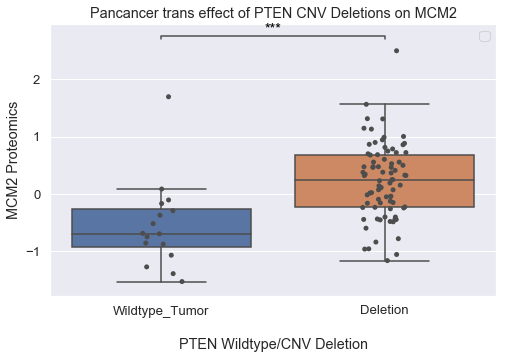

In [13]:
gene = 'PTEN'
plt.rcParams['figure.figsize']=(8,5) #size of plot
sns.set(font_scale = 1.2)

boxplot = sns.boxplot(x='Mutation', y=t_gene+"_proteomics", data = g_del_wt,
                      order = ["Wildtype_Tumor", "Deletion"], showfliers = False)    
boxplot.set_title('Pancancer trans effect of PTEN CNV Deletions on '+t_gene)
boxplot = sns.stripplot(x='Mutation', y=t_gene+"_proteomics", data = g_del_wt, jitter = True, 
                           color = ".3", order = ["Wildtype_Tumor", "Deletion"],dodge = True)
boxplot.set(xlabel = "\n"+gene+" Wildtype/CNV Deletion", ylabel = t_gene+' Proteomics')

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:3], labels[0:3])


# Create significance symbols:
# * P ≤ 0.05   ** P ≤ 0.01   *** P ≤ 0.001 
pvals = [gp] # same order as appended in long df
symbols = {}

for p in pvals:
    if p <= 0.001:
        symbols[p] = '***'
    elif p <= 0.01:
        symbols[p] = '**'
    elif p <= .05:
        symbols[p] = '*'
    else:
        symbols[p] = 'ns'
#print(symbols)

format_pval_annotation(symbols[gp], 0, 1, 2.7) # Gbm


plt.show()
plt.clf()
plt.close()

In [ ]:
# Save figure
#fig = boxplot.get_figure()
#fig.savefig(".png")